### Demo of using HMMS for sequence classification

    1. Create two Hidden Markov Models
    2. Generate sample sequences from each model.
    3. Split these test sequences into train/test partitions
    4. Train a Classifer containing an HMM for each label
        a. Train 10 models of each label, selecting the model with the lowest LogLikelihood
    
    5. Predict labels using Maximum Likelihood (ignoring class priors)
    6. Predict labels using Maximum A Posteriori
    7. Predict Labels using MLE, but using the original generating HMMS

In [2]:
import sys

In [3]:
sys.path.insert(0, "..")

In [4]:
from hmm import CategoricalHMM, HMMSearch, HMMClassifier, model_selection, distance, plots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.metrics

In [5]:
%matplotlib inline

### Two separate HMM definitions

Different initializations for pi and A, but B is the same

In [6]:
pi_1 = [ .5, .3, .2]
A_1 = [ [0.6, 0.3, 0.1], 
       [0.4, 0.4, 0.2],
       [0.1, 0.3, 0.6]
      ]
B_1 = [
    [0.5, 0.4, 0.1],
    [0.1, 0.3, 0.6],
    [0.6, 0.2, 0.2]
]

pi_2 = [ .4, .6]
A_2 = [ [0.8, 0.2], [0.6, 0.4]]
B_2 = [
    [0.2, 0.3, 0.5],
    [0.3, 0.3, 0.3]
]


### Generate sample data

In [7]:
hmm1 = CategoricalHMM.CategoricalHMM(
    n_iterations=0,
    init_pi=None,
    init_emissions=None,
    init_A=None,
    implementation="cython",
)
hmm1.pi_ = pi_1
hmm1.A_ = A_1
hmm1.B_ = B_1

In [8]:
print(hmm1.pi_)
print(hmm1.A_)
print(hmm1.B_)

[0.5, 0.3, 0.2]
[[0.6, 0.3, 0.1], [0.4, 0.4, 0.2], [0.1, 0.3, 0.6]]
[[0.5, 0.4, 0.1], [0.1, 0.3, 0.6], [0.6, 0.2, 0.2]]


In [9]:
hmm2 = CategoricalHMM.CategoricalHMM(
    n_iterations=0,
    init_pi=None,
    init_emissions=None,
    init_A=None,
    implementation="cython",
)
hmm2.pi_ = pi_2
hmm2.A_ = A_2
hmm2.B_ = B_2

In [10]:
print(hmm2.pi_)
print(hmm2.A_)
print(hmm2.B_)

[0.4, 0.6]
[[0.8, 0.2], [0.6, 0.4]]
[[0.2, 0.3, 0.5], [0.3, 0.3, 0.3]]


### Train on an imbalanced dataset

In [11]:
a_observations, a_hiddens = hmm1.sample(n_samples=2000, length=50)
b_observations, b_hiddens = hmm2.sample(n_samples=1000, length=50)

In [12]:
a_train_observations, a_test_observations = sklearn.model_selection.train_test_split(a_observations)
b_train_observations, b_test_observations = sklearn.model_selection.train_test_split(b_observations)

X_train = np.concatenate([a_train_observations, b_train_observations])
y_train = np.asarray(["class-a"] * len(a_train_observations) + ["class-b"] * len(b_train_observations))
X_test = np.concatenate([a_test_observations, b_test_observations])
y_test = np.asarray(["class-a"] * len(a_test_observations) + ["class-b"] * len(b_test_observations))


In [13]:
pd.Series(y_train).value_counts()

class-a    1500
class-b     750
dtype: int64

### Train the classifier 
I don't quite have it working to select an optimal number of states. In the literature AIC, BIC, Cross Validation are all mentioned as options, with conflicting advice.  The marketing literature also measures how well the hidden states are separated from each other, and there is interesting work done in the biological world, especially with regards to animal tracking.  Also can look at the how things are done in the Protien/dna sequencing field

 * https://core.ac.uk/download/pdf/82597511.pdf (Analysis of Genome Data)
 * https://arxiv.org/abs/1701.08673 (HMM Selection with Animal tracking applications)
 * http://etd.fcla.edu/UF/UFE0041157/zhang_x.pdf (Doctoral Thesis - yikes)
 * http://www.columbia.edu/~on2110/Papers/Ebbes_Netzer_2018.pdf (arketing science)

Instead, we'll fix the number of states, and train 10 models for each state, keeping the model that best approximates the generated data.

In [14]:
a_new = HMMSearch.HMMSearch(
    CategoricalHMM.CategoricalHMM(
        n_components=3,
        n_iterations=1000,
        implementation="cython",
    ),
    n_jobs=4,
    n_inits=2,
    n_components=[1,2,3,4,5, 6, 7],
    verbose=True,
)

b_new = HMMSearch.HMMSearch(
    CategoricalHMM.CategoricalHMM(
        n_components=2,
        n_iterations=1000,
        implementation="cython"
    ),
    n_jobs=4,
    n_inits=2,
    n_components=[1,2,3,4,5, 6, 7],
    verbose=True,

)

# Classifier with models learned from the data
classifier_mle = HMMClassifier.HMMClassifier(
    {
        "class-a": a_new,
        "class-b": b_new,
        
    },
    predict_method="mle",
)

classifier_map = HMMClassifier.HMMClassifier(
    {
        "class-a": a_new,
        "class-b": b_new,
        
    },
    predict_method="map",
)

# Classifer using the models that generated the data
original = HMMClassifier.HMMClassifier(
    {
        "class-a": hmm1,
        "class-b": hmm2,
    },
    predict_method="mle"
)

In [15]:
%time classifier_mle.fit(X_train, y_train)

/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 out of  14 | elapsed:  2.3min finished


Not Exchanging at 1: -54.5099232597224 for -54.5099232597224
Exchanging at 2: -54.4822500437776 for -54.48195605049839
Not Exchanging at 3: -54.47799280621498 for -54.47810397609206
Not Exchanging at 4: -54.477518339336484 for -54.477794030693275
Exchanging at 5: -54.47762642990458 for -54.47748717341661
Not Exchanging at 6: -54.4768739522967 for -54.47752336161428


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  14 | elapsed:   24.9s remaining:   24.9s
[Parallel(n_jobs=4)]: Done  14 out of  14 | elapsed:  2.0min finished


Exchanging at 7: -54.47715158249744 for -54.47710779488286
Not Exchanging at 1: -53.06486272255188 for -53.06486272255188
Not Exchanging at 2: -53.06005428432071 for -53.06060328329071
Exchanging at 3: -53.05826706528027 for -53.05813866876605
Not Exchanging at 4: -53.0539529110109 for -53.05527804499758
Exchanging at 5: -53.054019134581324 for -53.05362140507701
Exchanging at 6: -53.05682643642824 for -53.05156276524318
Exchanging at 7: -53.05775225482728 for -53.05299097683494
CPU times: user 1.07 s, sys: 31.8 ms, total: 1.1 s
Wall time: 4min 19s


HMMClassifier(default_estimator=CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=1, n_features=None, n_inits=1, n_iterations=100,
        n_jobs=-1, random_state=None, smoothing=None, tol=1e-06, verbose=0),
       estimators={'class-a': HMMSearch(criterion='bic',
     estimator=CategoricalHMM(allowed_to_use_log=True, implementation='cython',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=3, n_features=None, n_inits=1, n_iterations=1000,
        n_jobs=-1, random_state...     n_components=[1, 2, 3, 4, 5, 6, 7], n_inits=2, n_jobs=4,
     random_state=None, verbose=True)},
       predict_method='mle')

In [16]:
%time classifier_map.fit(X_train, y_train)

/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  14 | elapsed:   46.8s remaining:   46.8s
[Parallel(n_jobs=4)]: Done  14 out of  14 | elapsed:  3.8min finished


Not Exchanging at 1: -54.5099232597224 for -54.5099232597224
Exchanging at 2: -54.48196429258882 for -54.48194257981327
Exchanging at 3: -54.47835664455883 for -54.47821822377509
Exchanging at 4: -54.47799135272141 for -54.477913917481445
Exchanging at 5: -54.477801380063084 for -54.47775121913594
Not Exchanging at 6: -54.47649836944329 for -54.477020779266915
Exchanging at 7: -54.47696401408951 for -54.47675238246723


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  14 | elapsed:   21.9s remaining:   21.9s
[Parallel(n_jobs=4)]: Done  14 out of  14 | elapsed:  2.2min finished


Not Exchanging at 1: -53.06486272255188 for -53.06486272255188
Not Exchanging at 2: -53.06001325354499 for -53.06219477311643
Not Exchanging at 3: -53.05570056544646 for -53.057323686933074
Not Exchanging at 4: -53.052962713431526 for -53.053687329940985
Not Exchanging at 5: -53.050825526994714 for -53.05202217991034
Not Exchanging at 6: -53.04998736184849 for -53.05033294042196
Not Exchanging at 7: -53.05362275873772 for -53.05562884855859
CPU times: user 995 ms, sys: 16.4 ms, total: 1.01 s
Wall time: 5min 59s


HMMClassifier(default_estimator=CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=1, n_features=None, n_inits=1, n_iterations=100,
        n_jobs=-1, random_state=None, smoothing=None, tol=1e-06, verbose=0),
       estimators={'class-a': HMMSearch(criterion='bic',
     estimator=CategoricalHMM(allowed_to_use_log=True, implementation='cython',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=3, n_features=None, n_inits=1, n_iterations=1000,
        n_jobs=-1, random_state...     n_components=[1, 2, 3, 4, 5, 6, 7], n_inits=2, n_jobs=4,
     random_state=None, verbose=True)},
       predict_method='map')

In [17]:
for k, model in classifier_mle.trained_models_["class-a"].bests_.items():
    print(k)
    
    print(model.B_)
    print()

1
[[0.39409333 0.31292    0.29298667]]

2
[[0.17452665 0.38535229 0.44012106]
 [0.59762173 0.24577854 0.15659973]]

3
[[0.14854964 0.42121892 0.43023144]
 [0.54383824 0.07007503 0.38608673]
 [0.52214566 0.40084656 0.07700778]]

4
[[0.59554697 0.14491903 0.25953401]
 [0.5374025  0.30178419 0.16081331]
 [0.09923781 0.29348391 0.60727828]
 [0.36633676 0.54458381 0.08907944]]

5
[[0.17498857 0.35310494 0.47190649]
 [0.39239804 0.33511889 0.27248308]
 [0.58779658 0.38113583 0.03106759]
 [0.14070692 0.43666469 0.42262839]
 [0.57219514 0.09751633 0.33028853]]

6
[[0.69787418 0.22366097 0.07846485]
 [0.4040788  0.17247668 0.42344451]
 [0.05343844 0.4663437  0.48021786]
 [0.1947739  0.17745944 0.62776667]
 [0.60146966 0.35181572 0.04671462]
 [0.21285389 0.49827274 0.28887338]]

7
[[0.04710985 0.5386487  0.41424145]
 [0.28772165 0.42910808 0.28317027]
 [0.69655769 0.03628725 0.26715506]
 [0.62570813 0.29059383 0.08369805]
 [0.53027293 0.4337301  0.03599697]
 [0.28892732 0.39664682 0.31442586]
 [

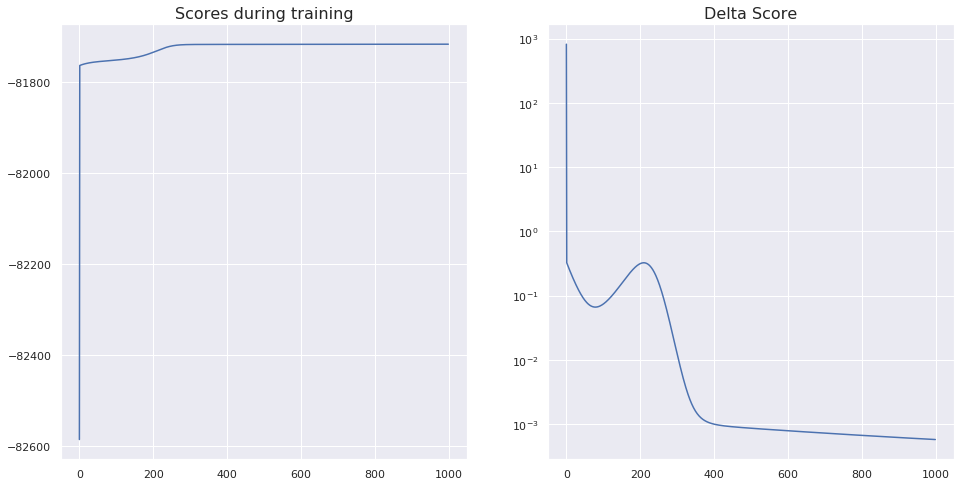

In [18]:
_ = plots.learning_plot(classifier_mle.trained_models_["class-a"].bests_[3].loglikelihoods_)

In [19]:
class_a_scores = pd.DataFrame(classifier_mle.trained_models_["class-a"].scores_).T
class_b_scores = pd.DataFrame(classifier_mle.trained_models_["class-b"].scores_).T

In [20]:
print(class_a_scores[["bic", "aic"]].idxmin())
class_a_scores[["bic", "aic", "score"]]

bic    2
aic    2
dtype: int64


bic            aic         score
1  163552.220266  163533.769779 -81764.884890
2  163524.404443  163459.827739 -81722.913870
3  163591.808079  163462.654671 -81717.327336
4  163691.922350  163479.741752 -81716.870876
5  163814.911933  163501.253657 -81716.626829
6  163957.081548  163523.495108 -81714.747554
7  164126.222238  163554.257147 -81715.128574

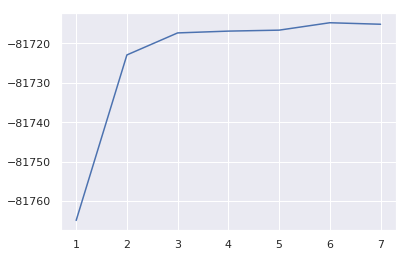

In [21]:
class_a_scores["score"].plot()

In [22]:
print(class_b_scores[["bic", "aic"]].idxmin())
class_b_scores[["bic", "aic"]]

bic    1
aic    1
dtype: int64


bic           aic
1  79618.358276  79601.294084
2  79663.744554  79604.019880
3  79731.000195  79611.550848
4  79821.682283  79625.444070
5  79934.329562  79644.238290
6  80069.989565  79668.981043
7  80233.424103  79704.434138

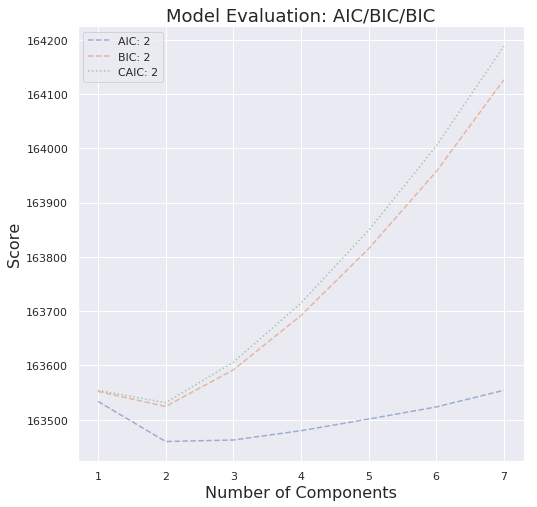

In [23]:
_ = model_selection.plot_bic_aic(classifier_mle.trained_models_["class-a"].scores_)

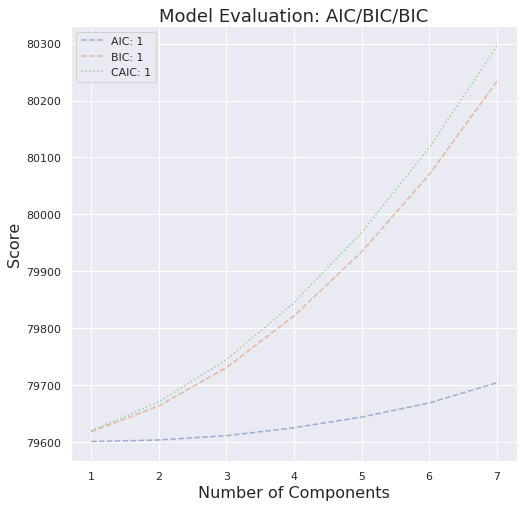

In [24]:
_ = model_selection.plot_bic_aic(classifier_mle.trained_models_["class-b"].scores_)

In [25]:
print(classifier_mle.trained_models_["class-a"].best_model_.loglikelihoods_[-10:])

[-81722.91507683026, -81722.91495579501, -81722.914834832, -81722.91471394114, -81722.91459312235, -81722.91447237559, -81722.9143517008, -81722.91423109791, -81722.91411056684, -81722.91399010754]


In [26]:
print("pi")
print(hmm1.pi_)
print(classifier_mle.trained_models_["class-a"].best_model_.pi_)
print("A")
print(hmm1.A_)
print(classifier_mle.trained_models_["class-a"].best_model_.A_)
print("B")
print(hmm1.B_)
print(classifier_mle.trained_models_["class-a"].best_model_.B_)


pi
[0.5 0.3 0.2]
[0.40506645 0.59493355]
A
[[0.6 0.3 0.1]
 [0.4 0.4 0.2]
 [0.1 0.3 0.6]]
[[0.56632354 0.43367646]
 [0.40491644 0.59508356]]
B
[[0.5 0.4 0.1]
 [0.1 0.3 0.6]
 [0.6 0.2 0.2]]
[[0.17452665 0.38535229 0.44012106]
 [0.59762173 0.24577854 0.15659973]]


##### Build the model based on the original distributions
Not really "fitting" the model, as we intialized it with zero iterations.

In [27]:
%time original.fit(X_train, y_train)

CPU times: user 5.01 ms, sys: 1.04 ms, total: 6.05 ms
Wall time: 5.36 ms


/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


HMMClassifier(default_estimator=CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=1, n_features=None, n_inits=1, n_iterations=100,
        n_jobs=-1, random_state=None, smoothing=None, tol=1e-06, verbose=0),
       estimators={'class-a': CategoricalHMM(allowed_to_use_log=True, implementation='cython', init_A=None,
        init_emissions=None, init_pi=None, n_components=3, n_features=None,
        n_inits=1, n_iterations=0, n_jobs=-1, random_state=None,
        smoothing=None, tol=1e-06, verbose=0), 'class-b': ...nits=1, n_iterations=0, n_jobs=-1, random_state=None,
        smoothing=None, tol=1e-06, verbose=0)},
       predict_method='mle')

In [28]:
y_test_proba_mle = classifier_mle.predict_proba(X_test)
y_test_proba_map = classifier_map.predict_proba(X_test)
y_origin_test_proba_mle = original.predict_proba(X_test)

In [29]:
y_test_proba_mle

array([[0.98960276, 0.01039724],
       [0.94591024, 0.05408976],
       [0.99297559, 0.00702441],
       ...,
       [0.07882099, 0.92117901],
       [0.04899317, 0.95100683],
       [0.12718094, 0.87281906]])

In [30]:
y_test_proba_map

array([[0.99477421, 0.00522579],
       [0.97220336, 0.02779664],
       [0.99647541, 0.00352459],
       ...,
       [0.14612431, 0.85387569],
       [0.0934099 , 0.9065901 ],
       [0.22566197, 0.77433803]])

In [31]:
np.exp(classifier_map.class_log_prior_)

array([0.66666667, 0.33333333])

In [32]:
print("Original HMM AUC")
print(sklearn.metrics.roc_auc_score(y_test, y_origin_test_proba_mle[:, 1]))
print("Learned HMM AUC: MLE")
print(sklearn.metrics.roc_auc_score(y_test, y_test_proba_mle[:, 1]))
print("Learned HMM AUC: MAP")
print(sklearn.metrics.roc_auc_score(y_test, y_test_proba_map[:, 1]))

Original HMM AUC
0.963416
Learned HMM AUC: MLE
0.961632
Learned HMM AUC: MAP
0.961632


### ROC
All models do well as the generating process is well separated

Text(0.5,1,'ROC - Classification example')

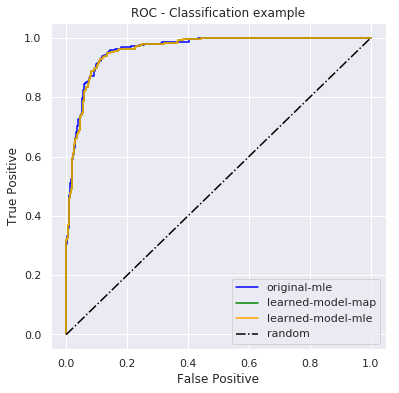

In [33]:
f, ax = plt.subplots(figsize=(6,6))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test == "class-b", y_origin_test_proba_mle[:, 1])
ax.plot(fpr, tpr, label="original-mle", color="blue")
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test == "class-b", y_test_proba_map[:, 1])
ax.plot(fpr, tpr, label="learned-model-map", color="green")
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test == "class-b", y_test_proba_mle[:, 1])
ax.plot(fpr, tpr, label="learned-model-mle", color="orange")
ax.plot(np.arange(0, 1.01, .1),np.arange(0, 1.01, .1), label="random", color="black", linestyle="-.")
ax.legend()
ax.set_ylabel("True Positive")
ax.set_xlabel("False Positive")
ax.set_title("ROC - Classification example")


In [34]:
predicted_y_mle = classifier_mle.predict(X_test)

predicted_y_map = classifier_map.predict(X_test)
predicted_y_orig_mle = original.predict(X_test)

### Standard Classification Metrics

In [35]:
print(sklearn.metrics.classification_report(y_test, predicted_y_mle))

              precision    recall  f1-score   support

     class-a       0.96      0.89      0.92       500
     class-b       0.81      0.92      0.86       250

   micro avg       0.90      0.90      0.90       750
   macro avg       0.88      0.91      0.89       750
weighted avg       0.91      0.90      0.90       750



In [36]:
print(sklearn.metrics.classification_report(y_test, predicted_y_map))

              precision    recall  f1-score   support

     class-a       0.94      0.92      0.93       500
     class-b       0.85      0.87      0.86       250

   micro avg       0.91      0.91      0.91       750
   macro avg       0.89      0.90      0.89       750
weighted avg       0.91      0.91      0.91       750



In [37]:
print(sklearn.metrics.classification_report(y_test, predicted_y_orig_mle))

              precision    recall  f1-score   support

     class-a       0.96      0.89      0.92       500
     class-b       0.81      0.92      0.86       250

   micro avg       0.90      0.90      0.90       750
   macro avg       0.88      0.91      0.89       750
weighted avg       0.91      0.90      0.90       750



### Model Distance 

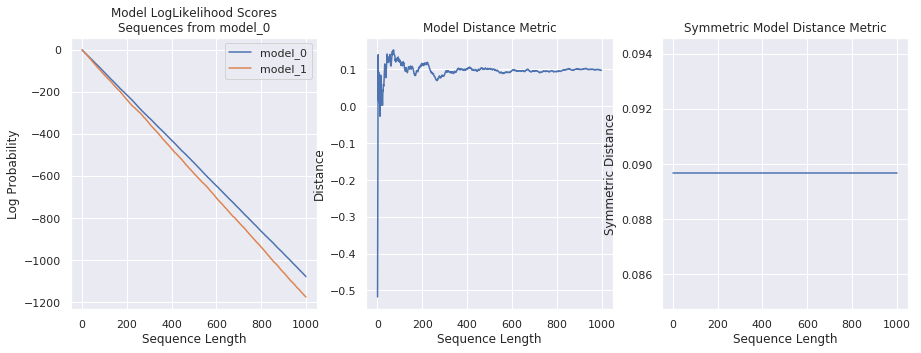

In [38]:
_ = distance.run_model_distance_tests(
    classifier_mle.estimators["class-a"].best_model_, 
    classifier_mle.estimators["class-b"].best_model_
)

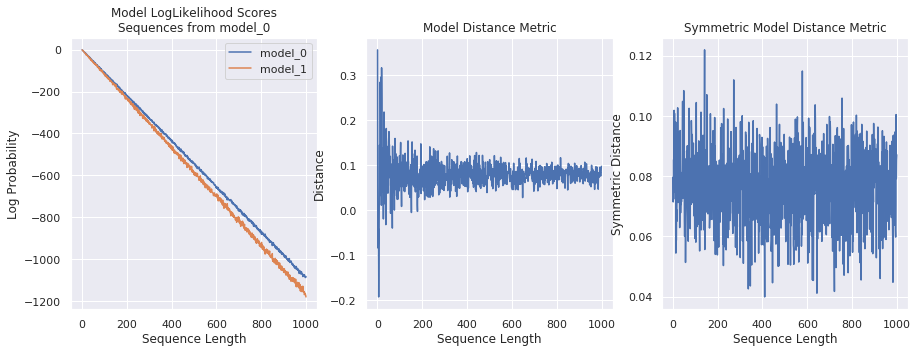

In [39]:
_ = distance.run_model_distance_tests(
    original.estimators["class-a"], 
    original.estimators["class-b"]
)

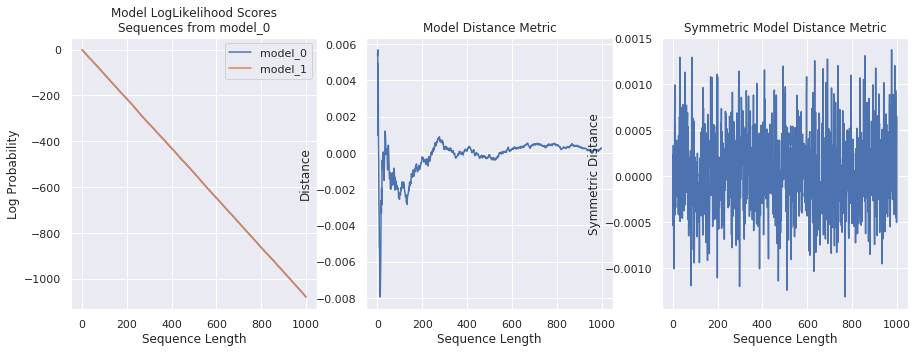

In [40]:
_ = distance.run_model_distance_tests(
    classifier_mle.estimators["class-a"].best_model_,
    original.estimators["class-a"]
)

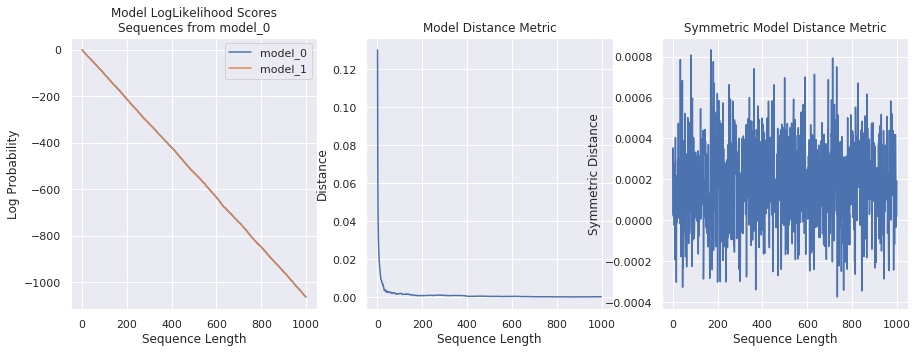

In [41]:
_ = distance.run_model_distance_tests(
    classifier_mle.estimators["class-b"].best_model_, 
    original.estimators["class-b"]
)